# 隱私強化技術上機教學
- 國家資通安全研究院　前瞻研究籌獲中心　隱私強化團隊製作
- ver. 20240626

## 程式庫導入

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.font_manager as fm

from rdt.transformers import AnonymizedFaker

from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer
from sdv.sampling import Condition
from sdv.evaluation.single_table import run_diagnostic
from sdmetrics.reports.single_table import QualityReport

from anonymeter.evaluators import SinglingOutEvaluator, LinkabilityEvaluator, InferenceEvaluator

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

import re
import logging
import warnings

In [2]:
fm.fontManager.addfont('NotoSansTC-VariableFont_wght.ttf')
plt.rcParams['font.sans-serif'] =  ['Noto Sans TC']
plt.rcParams['axes.unicode_minus']=False                # 用來正常顯示負號
warnings.simplefilter(action='ignore', category=FutureWarning)

# 資料集說明

我們今日要操作的是【白領信貸 (white-collar-loan)】這個資料集。
- 裡面是 2023 年全年度的信用貸款申請戶。
- 共 100,000 筆資料
- 有以下欄位：
  - 姓名 (category[str]): 貸款人姓名。
  - 身分證字號 (category[str]): 貸款人身分證字號。
  - 性別 (category[str]): 貸款人性別。男/女
  - 生日 (date): 貸款人生日。
  - 郵遞區號 (category[int]): 貸款人郵遞區號六碼。
  - 年收入-萬 (int): 貸款人申貸前一年年收入。以新台幣萬元計價，已四捨五入。忽略不同薪資結構
  - 貸款申請日 (date): 貸款人最後一次申貸日期。只有 2023 年申請的客戶記錄才會出現在這
  - 貸款金額-萬 (int): 貸款人最後一次申貸金額。以新台幣萬元計價，已四捨五入
- 本資料集為客戶觀點，一個客戶只有一筆資料，多次申貸以最後一次為準。
- 本資料集不存在遺失欄位。
- 本資料集為資安院為教育訓練訂製的模擬資料集，純屬虛構，與真實人物、地點無關，如有雷同，實屬巧合。

## 資料讀取

In [3]:
raw_data: pd.DataFrame = pd.read_csv('Prepared_data/white-collar-loan.csv', parse_dates=['生日', '貸款申請日'], dtype={'郵遞區號': 'category'})
print(f'資料集共有 {raw_data.shape[0]} 筆資料，{raw_data.shape[1]} 個欄位')
print(f'資料集中類別變項的欄位為：{raw_data.select_dtypes(include=["object","category"]).columns.tolist()}')
print(f'資料集中數值變項的欄位為：{raw_data.select_dtypes(include="number").columns.tolist()}')
print(f'資料集中日期的欄位為：{raw_data.select_dtypes(include="datetime").columns.tolist()}')

資料集共有 100000 筆資料，8 個欄位
資料集中類別變項的欄位為：['姓名', '身分證字號', '性別', '郵遞區號']
資料集中數值變項的欄位為：['年收入-萬', '貸款金額-萬']
資料集中日期的欄位為：['生日', '貸款申請日']


## 資料預覽

In [4]:
raw_data.head(6)

,姓名,身分證字號,性別,生日,郵遞區號,年收入-萬,貸款申請日,貸款金額-萬
0,吳哲瑋,F731721195,男,1991-11-23,505002,85,2023-01-29,48
1,劉柏翰,P979481390,男,2001-06-11,461002,37,2023-09-23,42
2,張佩珊,N230807599,女,1990-02-16,397002,44,2023-07-28,9
3,蘭佳穎,X098111112,女,1996-09-06,582002,224,2023-03-07,9
4,謝宇軒,P748394101,男,1985-11-30,923002,57,2023-04-21,42
5,蔣志偉,U106191481,男,1989-04-15,774001,162,2023-03-20,42


## 敘述統計

In [5]:
df_draw = raw_data.copy()

### 性別

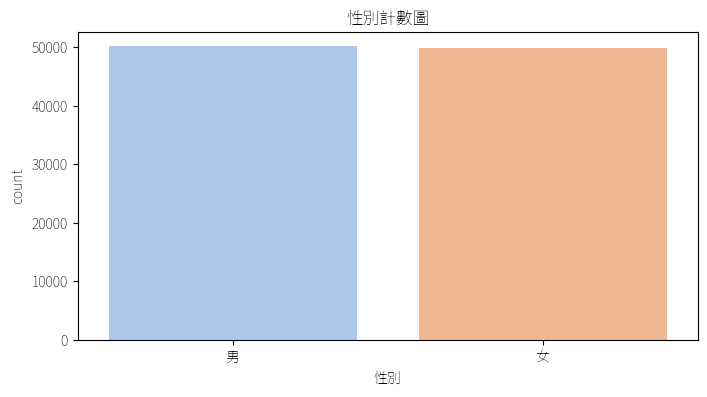

In [6]:
plt.figure(figsize=(8,4))

hue_order = df_draw['性別'].unique()[::1] # reverse
sns.countplot(x='性別', data=df_draw, hue='性別', hue_order=hue_order, palette='pastel')
plt.title('性別計數圖')

plt.show()

### 年收入、貸款金額

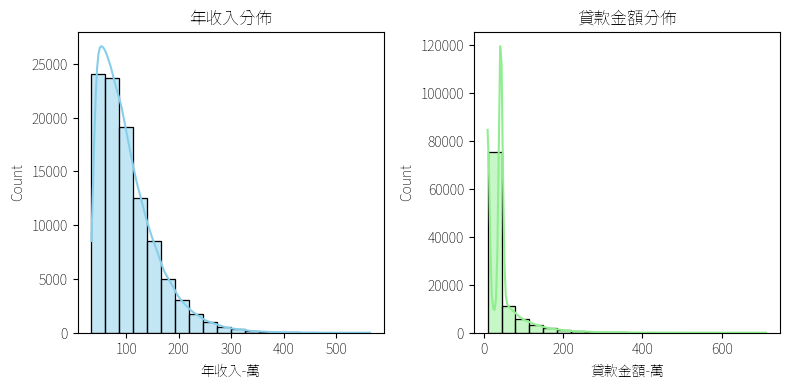

In [7]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.histplot(df_draw['年收入-萬'], bins=20, kde=True, color='skyblue')
plt.title('年收入分佈')

plt.subplot(1, 2, 2)
sns.histplot(df_draw['貸款金額-萬'], bins=20, kde=True, color='lightgreen')
plt.title('貸款金額分佈')

plt.tight_layout()
plt.show()

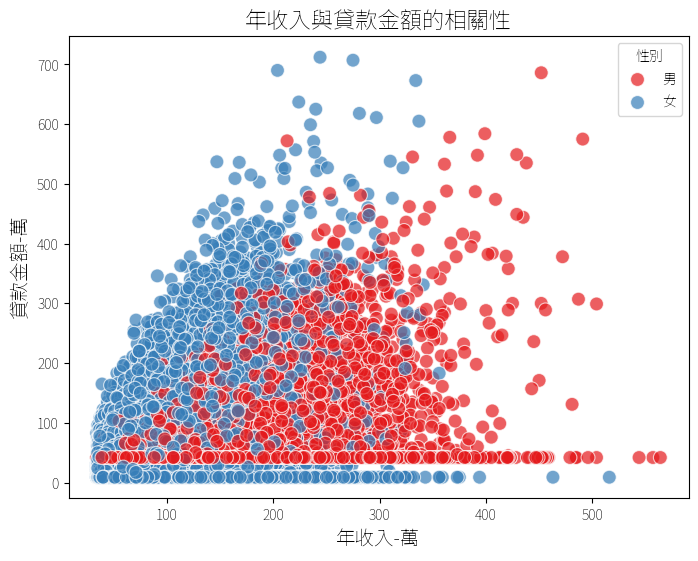

In [8]:
plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_draw, x='年收入-萬', y='貸款金額-萬', hue='性別', palette='Set1', alpha=0.7, s=100)
plt.title('年收入與貸款金額的相關性', fontsize=16)
plt.xlabel('年收入-萬', fontsize=14)
plt.ylabel('貸款金額-萬', fontsize=14)
plt.legend(title='性別')

plt.show()

### 性別 x 年收入、貸款金額

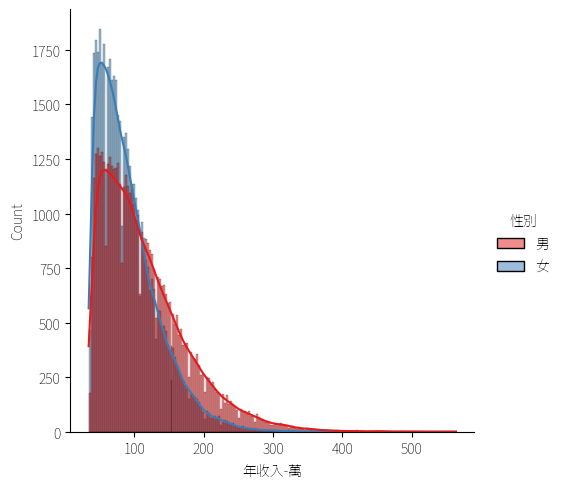

In [9]:
sns.displot(df_draw, x='年收入-萬', kde=True, hue='性別', palette='Set1')

# SDV

為了後續分析，我們先預留一部分的原始資料作為後續的測試資料。

In [10]:
train_data, test_data = train_test_split(raw_data, test_size=0.2, random_state=0)

## 準備資料

在 SDV 中，進行資料合成前，套件會需要先知道資料的格式，才能為每個欄位選擇適合的前處理方式與合成方法。這個讓套件讀取的資料格式資料稱作 metadata，在 SDV 內可用 `SingleTableMetadata.detect_from_dataframe()` 產生出 metadata。以下示範如何產生。

> 同場加映：
> 
> SDV 也有提供[直接讀取 `csv` 檔的功能](https://docs.sdv.dev/sdv/single-table-data/data-preparation/loading-data#load_csvs)，可讀取整個資料夾內的所有 `csv` 檔，並儲存成 `dict` 格式。需注意的是，metadata 仍須由使用者自行讀取。

In [11]:
# 產生物件
metadata = SingleTableMetadata()

# 從資料集中擷取欄位資訊，並將其存入 metadata 物件中
metadata.detect_from_dataframe(train_data)

> 同場加映：
>
> metadata 也可以使用 `detect_from_csv` 直接從 `csv` 檔讀取。

讀取 metadata 後可以進行檢視，確認格式是否正確。

In [12]:
metadata.to_dict()

{'primary_key': '身分證字號',
 'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
 'columns': {'姓名': {'sdtype': 'categorical'},
  '身分證字號': {'sdtype': 'id'},
  '性別': {'sdtype': 'categorical'},
  '生日': {'sdtype': 'datetime'},
  '郵遞區號': {'sdtype': 'categorical'},
  '年收入-萬': {'sdtype': 'numerical'},
  '貸款申請日': {'sdtype': 'datetime'},
  '貸款金額-萬': {'sdtype': 'numerical'}}}

可以看到套件自動設定了 `'primary_key'`，代表此份資料集中的獨一無二識別欄位，在整份資料集中，每筆資料的此欄位不得重複。除此之外，`'METADATA_SPEC_VERSION'` 記錄了當前使用的 metadata 版本，而 `'columns'` 為一巢狀 `dict`，記錄每個欄位的資料型態，其中 `'sdtype'` 為 SDV 使用的自定義資料類別，原則上有以下五類：

1. `boolean`
2. `categorical`
3. `datetime`
4. `numerical`
5. `id`

但還有一些衍伸類別可以使用，如：`phone_number`, `email`, `name`, `first_name`, `last_name`, `country_code`, `city`, `latitude`, `longtitude`, `ipv4_address`, `iban`, `credit_card_number`, `swift8` 等地區限定或個人識別資訊等。所有類別詳見[官方 SDTypes 文件](https://docs.sdv.dev/sdv/reference/metadata-spec/sdtypes)。

從上面的欄位我們可以觀察到姓名被分錯類別了：它應該是 `name` 而非 `categorical`，因此我們需要將它調整成正確的格式。同時也可將郵遞區號調整為 `text` 更符合後續應用，我們也需要同步調整在 `pandas` 中的資料型態，因為 SDV 會去檢查合成資料與原始資料的型態是否符合。

In [15]:
metadata.update_column(column_name='姓名', sdtype='name', pii=True)
metadata.update_column(column_name='郵遞區號', sdtype='text', pii=True)

In [16]:
train_data['郵遞區號'] = train_data['郵遞區號'].astype(str)

In [17]:
test_data['郵遞區號'] = test_data['郵遞區號'].astype(str)

In [18]:
metadata.to_dict()

{'primary_key': '身分證字號',
 'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
 'columns': {'姓名': {'sdtype': 'name', 'pii': True},
  '身分證字號': {'sdtype': 'id'},
  '性別': {'sdtype': 'categorical'},
  '生日': {'sdtype': 'datetime'},
  '郵遞區號': {'sdtype': 'text', 'pii': True},
  '年收入-萬': {'sdtype': 'numerical'},
  '貸款申請日': {'sdtype': 'datetime'},
  '貸款金額-萬': {'sdtype': 'numerical'}}}

除此之外，是否需要 Primary Key 也是能進行調整的。例如要把身分證字號從 Primary Key 移除：

In [19]:
metadata.remove_primary_key()

In [20]:
metadata.to_dict()

{'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
 'columns': {'姓名': {'sdtype': 'name', 'pii': True},
  '身分證字號': {'sdtype': 'id'},
  '性別': {'sdtype': 'categorical'},
  '生日': {'sdtype': 'datetime'},
  '郵遞區號': {'sdtype': 'text', 'pii': True},
  '年收入-萬': {'sdtype': 'numerical'},
  '貸款申請日': {'sdtype': 'datetime'},
  '貸款金額-萬': {'sdtype': 'numerical'}}}

也可以重新設定 Primary Key:

In [21]:
metadata.set_primary_key('身分證字號')

In [22]:
metadata.to_dict()

{'primary_key': '身分證字號',
 'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
 'columns': {'姓名': {'sdtype': 'name', 'pii': True},
  '身分證字號': {'sdtype': 'id'},
  '性別': {'sdtype': 'categorical'},
  '生日': {'sdtype': 'datetime'},
  '郵遞區號': {'sdtype': 'text', 'pii': True},
  '年收入-萬': {'sdtype': 'numerical'},
  '貸款申請日': {'sdtype': 'datetime'},
  '貸款金額-萬': {'sdtype': 'numerical'}}}

當我們進行完調整後（或者使用自定義的 metadata），可以利用 `validate()` 方法來檢驗目前的 metadata 是否符合格式。

In [23]:
metadata.validate()

另外也可檢查資料是否符合當前定義的 metadata。

In [24]:
metadata.validate_data(train_data)

> 同場加映：
>
> metadata 本身可以直接進行欄位的調整，例如可以用 [`add_column`](https://docs.sdv.dev/sdv/single-table-data/data-preparation/single-table-metadata-api#add_column) 方法新增欄位。`metadata.add_column(column_name, sdtype, **kwargs)`
>
> 如果特定欄位間有關聯（地址、GPS 資訊），可以使用 [`add_column_relationship`](https://docs.sdv.dev/sdv/single-table-data/data-preparation/single-table-metadata-api#add_column_relationship) 方法將這些欄位串連起來。`metadata.add_column_relationship(relationship_type, column_names)`

若有需要，metadata 可以用 `json` 的方式儲存，供未來使用。

In [ ]:
# 將 metadata 物件存成 JSON 檔案
# metadata.save_to_json('my_metadata.json')

# 從 JSON 檔案中載入 metadata 物件
# metadata = SingleTableMetadata.load_from_json('Prepared_data/my_metadata.json')

如果熟悉 SDV 的 metadata 格式，也可以直接寫成一個 `dict` 並讓物件自行讀入。

In [26]:
my_metadata_dict = {
    'primary_key': '身分證字號',
    'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
    'columns': {
        '姓名': {'sdtype': 'name', 'pii': True},
        '身分證字號': {'sdtype': 'id'},
        '性別': {'sdtype': 'categorical'},
        '生日': {'sdtype': 'datetime'},
        '郵遞區號': {'sdtype': 'text'},
        '年收入-萬': {'sdtype': 'numerical'},
        '貸款申請日': {'sdtype': 'datetime'},
        '貸款金額-萬': {'sdtype': 'numerical'}
    }
}

metadata = SingleTableMetadata.load_from_dict(my_metadata_dict)

## 建模

建模階段指的是合成器會去學習資料的結構，以生成出合成資料。在讓合成器學習前，我們需要確保資料符合要求：皆為數值資料且沒有遺失值。另外我們也可以在此階段加入一些限制，讓合成器後續生成的資料更貼近真實資料。

在 SDV 中，資料在訓練前會先經過資料前處理，這部分是由另一個套件 [RDT](https://docs.sdv.dev/rdt) 進行處理。除非要修改前處理過程，否則使用者不需要主動去呼叫此套件，SDV 會自行處理前處理的過程。

在這份教材中，會示範使用三種 SDV 的合成方法：Gaussian Copula, TVAE, CTGAN。在此我們先以 Gaussian Copula 作為例子進行講解。

### 前處理

In [27]:
# 先實體化 GaussianCopulaSynthesizer 類別，以進行 Gaussian Copula 合成
# 此時需要傳入 metadata 物件
synthesizer = GaussianCopulaSynthesizer(metadata=metadata)

這時我們可以再傳入欲被合成的資料，讓合成器決定每個欄位該使用何種前處理。

In [28]:
synthesizer.auto_assign_transformers(train_data)

接著來看合成器的預設前處理方式。

In [29]:
synthesizer.get_transformers()

{'姓名': AnonymizedFaker(provider_name='person', function_name='name'),
 '身分證字號': IDGenerator(prefix='sdv-id-'),
 '性別': UniformEncoder(),
 '生日': UnixTimestampEncoder(enforce_min_max_values=True),
 '郵遞區號': AnonymizedFaker(provider_name='lorem', function_name='text'),
 '年收入-萬': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 '貸款申請日': UnixTimestampEncoder(enforce_min_max_values=True),
 '貸款金額-萬': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True)}

在 SDV 中，每種資料型別會有預設的資料處理類型：

| SDType | 預設處理方式 |
|---|---|
| `boolean` | `UniformEncoder()` |
| `categorical` | `UniformEncoder()` |
| `datetime` | `UnixTimestampEncoder(enforce_min_max_values=True)` |
| `numerical` | `FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True)` |
| `id` | `IDGenerator(prefix='sdv-id-')` |

當然在 SDV/RDT 套件中還有提供更多種的前處理方式可供選擇，以下列舉部分簡單說明：

| 前處理方式 | 簡易原理介紹 | 預設套用資料類型 |
|---|---|---|
|`NullTransformer`| 填補遺失值，在還原時隨機抽樣插入遺失值 | - |
|`BinaryEncoder`| 填補遺失值，並將資料轉換為浮點數 | - |
|[`UniformEncoder`](https://datacebo.com/blog/improvement-uniform-encoder/)| 計算每個類別對應的 Uniform Distribution 區間，遺失值也被視作一類 | `boolean`, `categorical` |
|`OrderedUniformEncoder`| 與 `UniformEncoder` 大致相同，但會留 0.1 的機率範圍給未出現的類別 | - |
|`OneHotEncoder`| 略 | - |
|`LabelEncoder`| 略 | - |
|`OrderedLabelEncoder`| 略 | - |
|`UnixTimestampEncoder`| 填補遺失值，並將資料轉換為浮點數 | `datetime` |
|`OptimizedTimestampEncoder`| 為 `UnixTimestampEncoder` 的調整版本 | - |
|`FloatFormatter`| 填補遺失值，並將資料轉換為浮點數 | `numerical` |
|`IDGenerator`| 在前處理階段會將資料捨棄，在生成階段才根據給定字根生成 ID | `id` |
|`RegexGenerator`| 在前處理階段會將資料捨棄，在生成階段才根據給定 regex 規則生成字串 | `text` |
|`AnonymizedFaker`| 在前處理階段會將資料捨棄，在生成階段才使用 [`Faker`](https://faker.readthedocs.io/en/master/providers.html) 套件生成資料 | `pii` 類資料 |

觀察目前的資料前處理方法，可以發現有幾個不合理之處：

1. 姓名目前是用 `Faker` 產生合成資料，但預設會產生英文姓名，因此必須調整成中文姓名
2. 身分證字號預設會被編碼成 sdv-id-0, sdv-id-1, ... 的形式，然而這不是身分證的編碼方式
3. 郵遞區號應由六位數字生成

針對這三個問題，我們可以透過修改 transformer 的方式處理。

In [31]:
# 指定姓名與身分證字號欄位使用台灣習慣進行合成
synthesizer.update_transformers(column_name_to_transformer= {
    '姓名': AnonymizedFaker(provider_name='person', function_name='name', locales='zh_TW', missing_value_generation=None),
    '身分證字號': AnonymizedFaker(provider_name='ssn', function_name='ssn', locales='zh_TW', cardinality_rule='unique', missing_value_generation=None),
    '郵遞區號': AnonymizedFaker(function_name='numerify', function_kwargs={'text': '%#####'}, missing_value_generation=None)
})

使用 `AnonymizedFaker` 需要使用 `Faker` 中的 `provider_name` 與 `function_name`，詳見 [`Faker` 的官方說明](https://faker.readthedocs.io/en/master/providers.html)。透過 `cardinality_rule` 可以指定生成資料能否重複 (`None`, `'unique'`, `'match'`)，而 `missing_value_generation` 則能決定是否要生成遺失值 (`'random'`, `None`)。

需要注意的是，這邊的姓名是獨立合成的，因此可能會遇到女生會有男性姓名或相反的狀況。若要避免此狀況，需將男女分開生成，並指定使用性別限定之姓名。或者後續再利用 `Faker` 套件自行手動調整。同理，這邊的姓名是獨立合成的，因此可能會遇到女生會有男性身分證字號或相反的狀況。若要避免此狀況，需將男女分開生成，並指定使用 regex 生成器。或者後續再利用 `Faker` 套件自行手動調整。而郵遞區號的部分，`Faker` 僅能產生三碼郵遞區號，因此改用其內建的數字生成方法來製作（`%` 代表生成 0 到 9 之間的數字，而 `#` 代表生成 1 到 9 之間的數字）。

In [32]:
synthesizer.get_transformers()

{'姓名': AnonymizedFaker(provider_name='person', function_name='name', locales='zh_TW'),
 '身分證字號': AnonymizedFaker(provider_name='ssn', function_name='ssn', locales='zh_TW', cardinality_rule='unique'),
 '性別': UniformEncoder(),
 '生日': UnixTimestampEncoder(enforce_min_max_values=True),
 '郵遞區號': AnonymizedFaker(function_name='numerify', function_kwargs={'text': '%#####'}),
 '年收入-萬': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True),
 '貸款申請日': UnixTimestampEncoder(enforce_min_max_values=True),
 '貸款金額-萬': FloatFormatter(learn_rounding_scheme=True, enforce_min_max_values=True)}

同時我們也可以在合成前對合成器加入一些限制，例如貸款申請日必須大於生日。目前內建的限制包含以下（可自行定義限制）：

|限制|簡易描述|適用於單欄/多欄資料|
|---|---|---|
|[Positive](https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/positive)|所有值必須大於 0|單欄|
|[Negative](https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/negative)|所有值必須小於 0|單欄|
|[ScalarInequality](https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/scalarinequality)|所有值必須大/小（等）於某個值|單欄|
|[ScalarRange](https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/scalarrange)|所有值必須介於某個範圍|單欄|
|[FixedIncrements](https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/fixedincrements)|所有值的變化幅度為固定值|單欄|
|[FixedCombinations](https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/fixedcombinations)|欄位組合為固定的|多欄|
|[OneHotEncoding](https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/onehotencoding)|欄位組合符合 One-hot encoding 要求|多欄|
|[Inequality](https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/inequality)|某欄位的值必須大於另一欄位|多欄|
|[Range](https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes/range)|某欄位的值必須介於其他欄位|多欄|

In [33]:
# 貸款申請日期必須大於生日
loan_constraint = {
    'constraint_class': 'Inequality',
    'constraint_parameters': {
        'low_column_name': '生日',
        'high_column_name': '貸款申請日'
    }
}

In [34]:
synthesizer.add_constraints(constraints=[loan_constraint])

完成前處理與限制定義的部分後，就可以進行資料的擬合。

In [35]:
synthesizer.get_constraints()

[{'constraint_class': 'Inequality',
  'constraint_parameters': {'low_column_name': '生日',
   'high_column_name': '貸款申請日'}}]

### 擬合

SDV 提供了三種主流的資料合成方法，比較如下：

![](Pic/Synthesizer.png)

From https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers

其中 DayZ 是只利用 metadata 產生出合成資料的方式，僅限付費企業用戶使用。Gaussian Copula 是透過統計擬合的方式計算邊際分配與聯合分配的參數，藉此產生出合成資料。CTGAN 則是利用生成對抗網路進行擬合。TVAE 則利用 VAE 的方法產生出合成資料。其中 Gaussian Copula 的計算量較小，擬合速度較快；後兩者則是採用深度學習的方法，利用已經定義好的結構進行模型的訓練，SDV 仍有提供部分參數可自行調整，並支援使用 GPU，詳見官方文件。

[Gaussian Copula 官方文件](https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/gaussiancopulasynthesizer)

[CTGAN 官方文件](https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/ctgansynthesizer)

[TVAE 官方文件](https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/tvaesynthesizer)

#### Gaussian Copula

透過 `get_learned_distributions()` 方法，我們可以得知每個欄位的擬合結果。SDV 預設使用 beta 分配進行擬合，因為 beta 分配可產生的分配形狀較為多樣，且運算速度快。詳細技術細節可見[這篇 paper](https://dai.lids.mit.edu/wp-content/uploads/2018/03/SDV.pdf)。

In [ ]:
synthesizer.fit(train_data)

我們也可以更改欲使用的分配，例如將年收入與貸款金額改成使用 gamma 分配。不過此更改需重新創建一個合成器物件。目前支援的分配有：norm, beta, truncnorm, uniform, gamma, gaussian_kde.

In [36]:
synthesizer_gaussian = GaussianCopulaSynthesizer(metadata=metadata, numerical_distributions={
    '年收入-萬': 'gamma',
    '貸款金額-萬': 'gamma'
})

synthesizer_gaussian.auto_assign_transformers(train_data)

synthesizer_gaussian.update_transformers(column_name_to_transformer={
    '姓名': AnonymizedFaker(provider_name='person', function_name='name',
                           locales='zh_TW', 
                           missing_value_generation=None),
    '身分證字號': AnonymizedFaker(provider_name='ssn', function_name='ssn',
                            locales='zh_TW', cardinality_rule='match',
                             missing_value_generation=None),
    '郵遞區號': AnonymizedFaker(function_name='numerify',
                            function_kwargs={'text': '%#####'},
                             missing_value_generation=None)
    }
)

synthesizer_gaussian.add_constraints(constraints=[loan_constraint])

In [37]:
# 13.0 sec

synthesizer_gaussian.fit(train_data)

In [38]:
synthesizer_gaussian.get_learned_distributions()

{'性別': {'distribution': 'beta',
  'learned_parameters': {'loc': 2.87806805239803e-05,
   'scale': 0.9999566681600562,
   'a': 1.00399796593458,
   'b': 1.0003173565294778}},
 '生日': {'distribution': 'beta',
  'learned_parameters': {'loc': 4.2491519999999994e+17,
   'scale': 5.994433490546467e+17,
   'a': 0.9871394477010661,
   'b': 0.9960370180224547}},
 '年收入-萬': {'distribution': 'gamma',
  'learned_parameters': {'a': 1.5203091307635237,
   'loc': 33.919581629336065,
   'scale': 45.01532647120281}},
 '貸款金額-萬': {'distribution': 'gamma',
  'learned_parameters': {'a': 0.433555296104248,
   'loc': 8.999999999999998,
   'scale': 1.7165134546593026}},
 '生日#貸款申請日': {'distribution': 'beta',
  'learned_parameters': {'loc': 41.01557788828872,
   'scale': 0.6769504186500946,
   'a': 1.3825168397182883,
   'b': 1.1040137014084794}}}

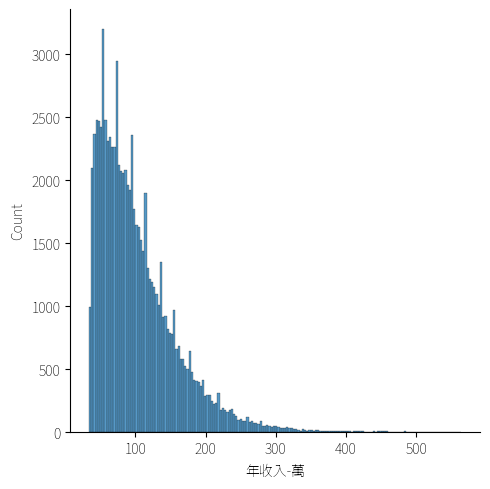

In [85]:
# 顯示特定欄位的分佈狀況
sns.displot(train_data['年收入-萬'])

In [86]:
rng = np.random.default_rng(seed=0)
# 產生 1000 筆符合 Gamma 分配的隨機數據
simulated_data = rng.gamma(shape=1.5203091307635237, scale=45.01532647120281, size=100000) + 33.919581629336065

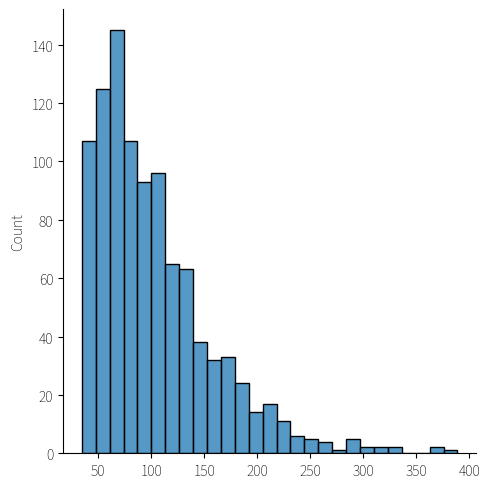

In [88]:
sns.displot(simulated_data)

我們也可以將擬合後的模型儲存下來，以供未來使用。

In [41]:
# synthesizer_gaussian.save('my_gaussian_model.pkl')

# synthesizer_gaussian = GaussianCopulaSynthesizer.load('Prepared_data/my_gaussian_model.pkl')

#### CTGAN

CTGAN 有提供部分訓練參數供使用者進行調整。其詳細技術細節可參考[這篇 paper](https://arxiv.org/pdf/1907.00503)。同時 SDV 也有提供相關的[參數調整建議](https://github.com/sdv-dev/SDV/discussions/980)以及[模型解讀方法](https://datacebo.com/blog/interpreting-ctgan-progress/)。

In [ ]:
synthesizer_ctgan = CTGANSynthesizer(metadata=metadata)

synthesizer_ctgan.auto_assign_transformers(train_data)

synthesizer_ctgan.update_transformers(column_name_to_transformer={
    '姓名': AnonymizedFaker(provider_name='person', function_name='name',
                           locales='zh_TW', 
                           missing_value_generation=None),
    '身分證字號': AnonymizedFaker(provider_name='ssn', function_name='ssn',
                            locales='zh_TW', cardinality_rule='match',
                             missing_value_generation=None),
    '郵遞區號': AnonymizedFaker(function_name='numerify',
                            function_kwargs={'text': '%#####'},
                             missing_value_generation=None)
    }
)

synthesizer_ctgan.add_constraints(constraints=[loan_constraint])

In [ ]:
# 28 min 53.1 sec

synthesizer_ctgan.fit(train_data)

In [ ]:
synthesizer_ctgan.get_lose_values()

我們可以畫出 Generator 與 Discriminator Loss 的比較，確認結果是否穩定。通常 Discriminator Loss 都會在 0 附近，而 Generator Loss 則是最終會趨於一穩定值（通常為負值）。

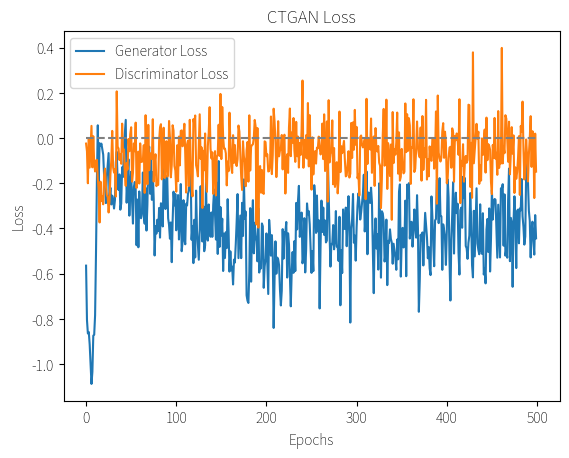

In [40]:
df_ctgan_loss = synthesizer_ctgan.get_loss_values()

plt.plot(df_ctgan_loss['Generator Loss'], label='Generator Loss')
plt.plot(df_ctgan_loss['Discriminator Loss'], label='Discriminator Loss')
plt.hlines(0, 0, df_ctgan_loss.shape[0], colors='gray', linestyles='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CTGAN Loss')
plt.legend()
plt.show()

In [39]:
# synthesizer_ctgan.save('my_ctgan_model.pkl')

synthesizer_ctgan = CTGANSynthesizer.load('Prepared_data/my_ctgan_model.pkl')

#### TVAE

TVAE 有提供部分訓練參數供使用者進行調整。其詳細技術細節可參考[這篇 paper](https://arxiv.org/pdf/1907.00503)。同時 SDV 也有提供相關的[參數調整建議](https://github.com/sdv-dev/SDV/discussions/980)以及[模型解讀方法](https://datacebo.com/blog/interpreting-ctgan-progress/)。

In [ ]:
synthesizer_tvae = TVAESynthesizer(metadata=metadata, epochs=500)

synthesizer_tvae.auto_assign_transformers(train_data)

synthesizer_tvae.update_transformers(column_name_to_transformer={
    '姓名': AnonymizedFaker(provider_name='person', function_name='name',
                           locales='zh_TW', 
                           missing_value_generation=None),
    '身分證字號': AnonymizedFaker(provider_name='ssn', function_name='ssn',
                            locales='zh_TW', cardinality_rule='match',
                             missing_value_generation=None),
    '郵遞區號': AnonymizedFaker(function_name='numerify',
                            function_kwargs={'text': '%#####'},
                             missing_value_generation=None)
    }
)

synthesizer_tvae.add_constraints(constraints=[loan_constraint])

In [ ]:
# 10 min 52.0 sec

synthesizer_tvae.fit(train_data)

In [ ]:
synthesizer_tvae.get_lose_values()

在此只呈現出其中一個 batch 的結果。理想上 Loss 應趨近於一穩定值（通常為負值）。

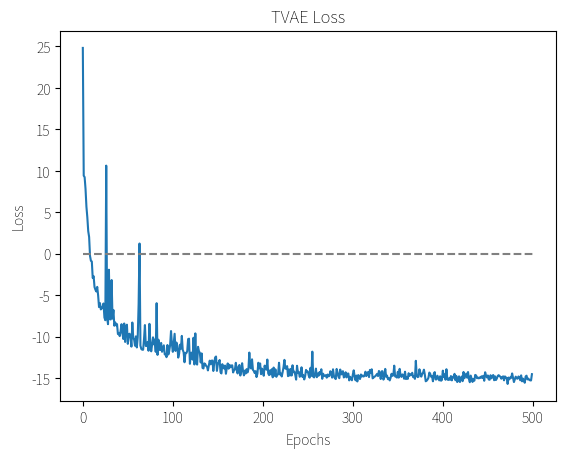

In [54]:
df_tvae_loss = synthesizer_tvae.get_loss_values()

plt.plot(df_tvae_loss.loc[df_tvae_loss.Batch == 0]['Epoch'], df_tvae_loss.loc[df_tvae_loss.Batch == 0]['Loss'])
plt.hlines(0, 0, 501, colors='gray', linestyles='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('TVAE Loss')
plt.show()

In [53]:
# synthesizer_tvae.save('my_tvae_model.pkl')

synthesizer_tvae = TVAESynthesizer.load('Prepared_data/my_tvae_model.pkl')

## 抽樣

當模型訓練好之後，就可以使用模型生成合成資料。此步驟稱為「抽樣」。SDV 提供兩種不同目的的抽樣方式：一般目的抽樣與條件抽樣。以下將分別介紹。在範例中皆使用 Gaussian Copula 合成器作為示範。

### 一般目的抽樣

在一般情況下，抽樣的目的即是為了產生與原始資料相近的資料。使用 `sample()` 方法即可達成，需指定欲生成的資料筆數（`num_rows`），也可以指定 `batch_size`, `max_tries_per_batch` 來決定每次生成資料的數量。也可以利用 `output_file_path` 將資料儲存下來。

In [42]:
synthetic_data_gaussian = synthesizer_gaussian.sample(num_rows=train_data.shape[0], batch_size=500)

Sampling rows: 100%|██████████| 80000/80000 [00:06<00:00, 11898.67it/s]


In [46]:
synthetic_data_gaussian.head(10)

,姓名,身分證字號,性別,生日,郵遞區號,年收入-萬,貸款申請日,貸款金額-萬
0,張佩君,X156467129,男,1990-07-18,849715,131,2023-09-09,13
1,林詩涵,Q200653543,男,1995-03-06,731247,71,2024-06-26,9
2,劉淑慧,N290569676,女,1987-06-01,432847,173,2022-06-07,9
3,陸淑芬,B189054288,女,1996-08-22,603987,56,2022-12-24,9
4,王羽,Y170186695,女,1991-02-16,813798,167,2022-11-09,9
5,劉淑娟,U159226110,男,1986-11-04,137049,190,2023-02-23,9
6,楊傑克,A182180319,女,2000-03-30,459423,111,2023-08-02,9
7,楊琬婷,B220057689,女,1989-11-21,127864,37,2021-03-27,9
8,王俊賢,E231565695,女,1998-01-26,688612,113,2023-11-09,9
9,彭筱涵,P169543650,女,1998-12-01,888851,112,2024-10-12,9


每次抽樣的結果都是隨機的，不過透過 `reset_sampling()` 可以重置整個隨機過程，因此使用後可以讓合成器回到一開始的狀態，抽樣出相同的資料。

In [49]:
# 第二次抽樣
synthesizer_gaussian.reset_sampling()

In [52]:
synthetic_data_gaussian.head(10)

,姓名,身分證字號,性別,生日,郵遞區號,年收入-萬,貸款申請日,貸款金額-萬
0,張佩君,X156467129,男,1990-07-18,849715,131,2023-09-09,13
1,林詩涵,Q200653543,男,1995-03-06,731247,71,2024-06-26,9
2,劉淑慧,N290569676,女,1987-06-01,432847,173,2022-06-07,9
3,陸淑芬,B189054288,女,1996-08-22,603987,56,2022-12-24,9
4,王羽,Y170186695,女,1991-02-16,813798,167,2022-11-09,9
5,劉淑娟,U159226110,男,1986-11-04,137049,190,2023-02-23,9
6,楊傑克,A182180319,女,2000-03-30,459423,111,2023-08-02,9
7,楊琬婷,B220057689,女,1989-11-21,127864,37,2021-03-27,9
8,王俊賢,E231565695,女,1998-01-26,688612,113,2023-11-09,9
9,彭筱涵,P169543650,女,1998-12-01,888851,112,2024-10-12,9


In [ ]:
synthesizer_gaussian.reset_sampling()

In [ ]:
synthetic_data_gaussian3 = synthesizer_gaussian.sample(num_rows=train_data.shape[0], batch_size=500)

In [ ]:
synthetic_data_gaussian3.head(10)

可以觀察到以上結果跟一開始一樣。

### 條件抽樣

在有些狀況下（例如：生成假設情境、資料去偏誤、推論未知值等），我們會希望合成資料中含有特定的值，這種目的可透過條件抽樣來達成。條件抽樣又可分為兩種：給定條件生成、給定部分欄位生成。以下將分別示範。

在給定條件生成的情況下，我們需要先建立 `Condition` 類別，再將此類別物件作為 `sample_from_conditions` 的參數，以便進行條件抽樣。

假設今天我們想要生成「貸款 10 萬元的男性」與「貸款 10 萬元的女性」各 50 筆資料，則可以透過以下的方式：

In [55]:
male_with_loan_10 = Condition(
    num_rows=50,
    column_values={'性別': '男', '貸款金額-萬': 10 }
)

female_with_loan_10 = Condition(
    num_rows=50,
    column_values={'性別': '女', '貸款金額-萬': 10 }
)

`sample_from_conditions()` 也有 `batch_size`, `max_tries_per_batch`, `output_file_path` 參數可供使用。

In [56]:
synthetic_data_condition = synthesizer_gaussian.sample_from_conditions(conditions=[male_with_loan_10, female_with_loan_10])

Sampling conditions: 100%|██████████| 100/100 [00:00<00:00, 655.26it/s]


In [57]:
synthetic_data_condition.head(10)

,姓名,身分證字號,性別,生日,郵遞區號,年收入-萬,貸款申請日,貸款金額-萬
0,劉雅筑,L227195108,男,1998-12-20,213853,73,2022-12-05,10
1,王柏翰,P196270337,男,1984-08-27,975424,177,2023-12-01,10
2,葛沖,Y231670767,男,1988-07-27,581822,68,2025-01-13,10
3,林雅玲,S299509670,男,1988-12-19,888114,44,2022-03-08,10
4,楊婷婷,Q185364696,男,1986-09-24,759663,89,2022-07-10,10
5,李中山,C192866908,男,1985-01-16,908730,58,2023-12-10,10
6,郭淑娟,B117671824,男,1994-03-07,268453,136,2023-04-06,10
7,劉郁婷,C272302512,男,2002-02-09,193542,86,2023-06-09,10
8,張怡伶,X138332909,男,1983-10-17,487646,52,2023-11-06,10
9,李欣怡,U182245787,男,1994-06-02,309834,143,2023-12-09,10


In [58]:
synthetic_data_condition.groupby(['性別', '貸款金額-萬']).size()

性別  貸款金額-萬
女   10        50
男   10        50
dtype: int64

如果我們已經知道部分欄位的資訊，則不須使用 `Condition` 類別，而是利用 `sample_remaining_columns` 並在 `known_columns` 參數中給予 `pd.DataFrame` 讓生成器自動補全剩下的欄位。例如我們有五筆關於性別跟年收入的資料，想補全剩下的欄位，則操作如下：

In [59]:
# 以下是我們擁有的不完整資料

incomplete_data = pd.DataFrame({'性別': ['男', '女', '男', '女', '男'], '年收入-萬': [100, 90, 80, 85, 77]})

In [60]:
incomplete_data

,性別,年收入-萬
0,男,100
1,女,90
2,男,80
3,女,85
4,男,77


In [62]:
synthetic_data_complete = synthesizer_gaussian.sample_remaining_columns(known_columns=incomplete_data)

Sampling remaining columns: 100%|██████████| 5/5 [00:00<00:00, 18.15it/s]


In [63]:
synthetic_data_complete

,姓名,身分證字號,性別,生日,郵遞區號,年收入-萬,貸款申請日,貸款金額-萬
0,劉依婷,P294869043,男,1994-05-17,766928,100,2022-11-11,9
1,方雅慧,Q155173525,女,1985-02-09,429480,90,2022-12-30,9
2,崔雅婷,D216553456,男,1984-07-20,327471,80,2024-03-13,11
3,葉欣怡,R235891678,女,1999-10-26,881975,85,2024-09-03,9
4,劉家瑋,O159592820,男,1991-06-26,511975,77,2024-04-15,10


`sample_remaining_columns()` 也有 `batch_size`, `max_tries_per_batch`, `output_file_path` 參數可供使用。

以上兩種條件抽樣方法都會保留模型學習到的資料特徵。需要注意的是，在某些情況下，合成器可能無法按照使用者的條件生成出所有的資料，尤其是 CTGAN 和 TVAE，因為它們是採用拒絕抽樣法來進行條件抽樣，在給定條件出現機會過小的情形下，其抽樣效率非常差。因此若遇到這種情形，建議可以使用較大的 `batch_size` 或 `max_tries_per_batch`，或者改用 Gaussian Copula 進行資料合成。

另外，使用限制的情形下，SDV 會採用拒絕抽樣法來符合限制，因此限制太多會導致執行效率變差。因此若遇到這種情形，建議可以使用較大的 `batch_size` 或 `max_tries_per_batch`，或者移除部分限制。

最後，若是使用者設定的條件超出值域，且在合成器中 `enforce_min_max_values` 設為 `True`，會導致合成器無法抽樣出符合條件的資料。因此若遇到這種情形，需將 `enforce_min_max_values` 設為 `False`。

# 評測

當我們產生合成資料後，我們會想要了解合成資料的品質。合成資料的評估可包含以下幾個面向：保真度、保護力、實用性。保真度是指合成資料是否與原始資料在統計分配上相似，我們可以用 SDV 內建的 SDMetrics 子套件來進行評估。保護力則是指此資料的隱私風險高低，其中一種評估方法是使用 `anonymeter` 套件，它將隱私風險分為三種：指認性 (Singling Out)、連結性 (Linkability) 和推斷性 (Inference) 的風險，後續將會詳述。實用性則檢驗合成資料是否實用，意即是否適合用於取代原始資料來執行下游任務。後續將進行此三項指標的評測示範。

In [ ]:
train_data = pd.read_csv('Prepared_data/train_data.csv')
test_data = pd.read_csv('Prepared_data/test_data.csv')
synthetic_data_gaussian = pd.read_csv('Prepared_data/synthetic_data_gaussian.csv')

## 資料診斷：SDMetrics

進行評測之前，我們會想要先確認一些更基本的性質：合成資料的資料格式（例如欄位數）是否跟原始資料相同？此前提成立後，再去進行其他諸如保真度、保護力的檢測才有意義。這部分也可以透過 SDV 內建的 SDMetrics 進行評估。評估的內容如下，其中 BoundaryAdherence 或 CategoryAdherence 會逐欄計算（根據欄位資料型態決定），而 KeyUniqueness 則是只有設為 Primary Key 的欄位才會進行計算。Data Validity 為所有計算值的平均，而 Data Structure 則為一單一分數。所有的值皆介於 0~1 (0~100%) 之間，越接近 1 越好。其中此指標理論上必須為 1。

| Property | Metrics | Description |
|---|---|---|
| Data Validity | KeyUniqueness | 確認 Primary keys 是有值且不重複的。 |
| Data Validity | BoundaryAdherence | 用於連續變項，合成資料所有值都在真實資料上下界中的比率 |
| Data Validity | CategoryAdherence | 用於類別變項，合成資料所有類別都在真實資料中的比率 |
| Data Structure | TableStructure | 確認原始資料與合成資料的欄位數是否一致 |

In [65]:
diagnostic_report = run_diagnostic(real_data=train_data, synthetic_data=synthetic_data_gaussian, metadata=metadata)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 420.52it/s]

Overall Score: 96.1%

Properties:
- Data Validity: 92.2%
- Data Structure: 100.0%


In [70]:
diagnostic_report.get_details(property_name='Data Validity')

,Column,Metric,Score
0,身分證字號,KeyUniqueness,1.000000
1,性別,CategoryAdherence,1.000000
2,生日,BoundaryAdherence,1.000000
3,年收入-萬,BoundaryAdherence,1.000000
4,貸款申請日,BoundaryAdherence,0.531825
5,貸款金額-萬,BoundaryAdherence,1.000000


In [67]:
diagnostic_report.get_details(property_name='Data Structure')

,Metric,Score
0,TableStructure,1.0


## 保真度：SDMetrics

在 SDV 中，保真度評估的指標如下。所有的值皆介於 0~1 (0~100%) 之間，越接近 1 代表保真度越好。100% 代表原始資料與合成資料的樣態完全一致，因此如果將原始資料與自身進行比較，分數必定為 100%。0% 則代表原始資料與合成資料的樣態完全不同。一般來說，保真度的分數絕對不會達到 100%，而是會介於 0~1 (0~100%) 之間的分數。評估方式如下，其中 Column Shapes 會逐欄比較計算，最後總分為為所有計算值的平均，而 Column Pair Trends 會以兩兩一組為單位比較計算，最後總分為為所有計算值的平均。

| Property | Metrics | Description |
|---|---|---|
| Column Shapes | KSComplement | 用於連續變項，計算 $1 - \text{Kolmogorov-Smirnov statistic}$ |
| Column Shapes | TVComplement | 用於類別變項，計算 $1 -$ 全變差距離 (TVD, Total Variation Distance) |
| Column Pair Trends | CorrelationSimilarity | 用於兩連續變項，比較原始資料兩欄位的相關係數與合成資料兩欄位的相關係數之差異 |
| Column Pair Trends | ContingencySimilarity | 用於兩類別變項，比較原始資料兩欄位的 TVD 與合成資料兩欄位的 TVD 之差異 |

> 同場加映：
>
> Kolmogorov-Smirnov statistic 計算的是兩分配的累積機率分配函數 (CDF, Cumulative Density Function)。
> 
> ![](Pic/KS.png)
>
> From https://docs.sdv.dev/sdmetrics/metrics/metrics-glossary/kscomplement

> 同場加映：
>
> TVD 的計算方式為 $\delta (R, S) = \frac{1}{2}\Sigma_{\omega\in\Omega}|R_{\omega}-S_{\omega}|$，其中 $\omega$ 代表該欄位 $\Omega$ 的所有可能組合。 $R$ 與 $S$ 則分別代表原始資料與合成資料該類別的出現頻率。
>
> ![](Pic/TVD.png)
>
> From https://docs.sdv.dev/sdmetrics/metrics/metrics-glossary/correlationsimilarity

> 同場加映：
>
> CorrelationSimilarity 中的相關係數可選用 Pearson 相關係數（預設）或 Spearman 相關係數。前者檢驗兩欄位的線性相關程度，後者則是檢驗兩欄位的單調相關程度（僅衡量排名）。需注意計算 Spearman 相關係數費時較久。CorrelationSimilarity 的計算方式為：$\text{score} = 1 - \frac{|S_{A, B} - R_{A, B}|}{2}$。其中 $A$, $B$ 為兩連續變數欄位。需注意的是，相關性不代表趨勢（斜率），因此在兩欄位沒有呈現線性關係時（相關性接近 0）時，若合成資料也捕捉到此現象，則在 CorrelationSimilarity 可能獲得高分。
>
> ![](Pic/Corr.png)
>
> From https://docs.sdv.dev/sdmetrics/metrics/metrics-glossary/correlationsimilarity

> 同場加映：
>
> ContingencySimilarity 的計算方式為：$\text{score} = 1 - \frac{1}{2}\Sigma_{\alpha\in A}\Sigma_{\beta\in B}|S_{\alpha, \beta}-R_{\alpha, \beta}|$。其中 $\alpha$ 代表在 $A$ 欄位中所有可能的類別而 $\beta$ 代表在 $B$ 欄位所有可能的類別。$R$ 和 $S$ 分別代表原始資料與合成資料在該類別的出現頻率。

> 同場加映：
>
> 目前沒有標準的流程以計算數值欄位與類別欄位間的相關性，一可行的做法是將數值欄位切分為數等分，使其變成類別欄位，再用類別欄位的方式進行計算。

In [68]:
report = QualityReport()

report.generate(real_data=train_data, synthetic_data=synthetic_data_gaussian, metadata=metadata.to_dict())

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 28/28 [00:00<00:00, 68.39it/s] 

Overall Score: 68.96%

Properties:
- Column Shapes: 80.15%
- Column Pair Trends: 57.77%


In [71]:
report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,性別,TVComplement,0.999112
1,生日,KSComplement,0.996363
2,年收入-萬,KSComplement,0.987413
3,貸款申請日,KSComplement,0.727000
4,貸款金額-萬,KSComplement,0.297413


In [73]:
report.get_details(property_name='Column Pair Trends')

,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,性別,生日,ContingencySimilarity,0.000000e+00,NaN,NaN
1,性別,年收入-萬,ContingencySimilarity,0.000000e+00,NaN,NaN
2,性別,貸款申請日,ContingencySimilarity,0.000000e+00,NaN,NaN
3,性別,貸款金額-萬,ContingencySimilarity,2.220446e-16,NaN,NaN
4,生日,年收入-萬,CorrelationSimilarity,9.980926e-01,-0.001771,0.002044
5,生日,貸款申請日,CorrelationSimilarity,8.951400e-01,-0.003162,0.206558
6,生日,貸款金額-萬,CorrelationSimilarity,9.973444e-01,-0.001626,-0.006937
7,年收入-萬,貸款申請日,CorrelationSimilarity,9.912967e-01,-0.024470,-0.007063
8,年收入-萬,貸款金額-萬,CorrelationSimilarity,9.012956e-01,0.328948,0.131539
9,貸款申請日,貸款金額-萬,CorrelationSimilarity,9.936096e-01,0.011160,-0.001621


如果在保真度的分數較低，則可以先了解造成低分的原因（利用 `get_details()`），再針對該欄位進行研究及處理。需注意的是，保真度分數低不代表下游任務的實用性低。

## 保護力：Anonymeter

`anonymeter` 是一個評估合成表格資料中不同層面隱私風險的 `Python` 函式庫，包括指認性 (Singling Out)、連結性 (Linkability)、和推斷性 (Inference) 風險。所有的值皆介於 0~1 之間，越接近 1 代表風險越高，保護力越低。詳細技術討論可見[這篇 paper](https://petsymposium.org/popets/2023/popets-2023-0055.pdf)。`anonymeter` 傾向用最保守的方式進行風險估計，因此它假設攻擊者擁有全部的合成資料，且擁有正確的關於原始資料的部分知識（auxiliary information），但沒辦法取用合成模型。在使用上需注意此方法需要一份沒有作為合成方法擬合對象的控制資料集作為控制攻擊率的計算，因此需要在訓練合成模型前先將拆分部分資料，不作為訓練之用。官方範例可見[此 notebook](https://github.com/statice/anonymeter/blob/main/notebooks/anonymeter_example.ipynb)。

### 指認性
  
合成資料中只有特定一筆資料有獨一無二的組合（在此我們用一半的欄位進行測試），不必然可以進行再辨認（即使知道這個資訊，也不代表可以知道這個人是誰）。

![](Pic/Singlingout.png)

In [74]:
train_data_revised = train_data.copy()
synthetic_data_gaussian_revised = synthetic_data_gaussian.copy()
test_data_revised = test_data.copy()

In [75]:
# 因為 anonymeter 的變數名稱限制，所以將原始資料的欄位名稱做修改

train_data_revised.rename(columns={'年收入-萬': '年收入'}, inplace=True)
train_data_revised.rename(columns={'貸款金額-萬': '貸款金額'}, inplace=True)
synthetic_data_gaussian_revised.rename(columns={'年收入-萬': '年收入'}, inplace=True)
synthetic_data_gaussian_revised.rename(columns={'貸款金額-萬': '貸款金額'}, inplace=True)
test_data_revised.rename(columns={'年收入-萬': '年收入'}, inplace=True)
test_data_revised.rename(columns={'貸款金額-萬': '貸款金額'}, inplace=True)

In [76]:
# 由於 anonymeter 套件在執行上有隨機性，可透過 logging 模組來追蹤錯誤訊息
file_handler = logging.FileHandler("anonymeter.log")

file_handler.setLevel(logging.DEBUG)

logger = logging.getLogger("anonymeter")
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

In [77]:
singlingout = SinglingOutEvaluator(ori=train_data_revised, syn=synthetic_data_gaussian_revised, control=test_data_revised, n_attacks=50)
singlingout.evaluate(mode='univariate')
risk = singlingout.risk()
print(risk)

PrivacyRisk(value=0.019260130035860284, ci=(0.0, 0.08314540970956837))


> 同場加映：
>
> `anonymeter` 也有多變數的版本，只需要在宣告物件時加入參數：`n_cols` 代表放入 query 的變數數目，以及在使用 `evaluate()` 方法時將參數改為 `mode='multivariate'` 即可。需注意其執行時間會大幅增加，因為會更難找到合適的 query，可在宣告物件時利用 `max_attempts` 控制搜尋次數。

> 同場加映：
>
> 以下程式碼解析風險的計算方式：
> 
> 在此之前，需先了解攻擊率的定義：攻擊者成功執行特定攻擊的比例，又可稱為攻擊成功率。而攻擊成功率可分為三種：主要攻擊率 (Main Attack Rate) 是指使用合成資料來推斷訓練資料紀錄的攻擊率、控制攻擊率 (Control Attack Rate) 則是使用合成資料來推斷控制資料紀錄的攻擊率、基線攻擊率 (Baseline Attack Rate) 則是使用隨機猜測來推斷訓練資料紀錄的成功率。如果主要攻擊率小於等於基線攻擊率，則代表主要攻擊的建模、其效果還不如隨機猜測，此時結果沒有意義。藉由主要攻擊率與控制攻擊率，可以計算前述之隱私風險，公式為：$$\text{Privacy Risk} = \frac{\text{Main Attack} - \text{Control Attack}}{1-\text{Control Attack}}$$
> 其中分子代表攻擊者利用合成資料的攻擊，也就是主要攻擊對控制攻擊成功率的進步程度，此量測目的是為了要分辨出攻擊者能夠成功攻擊是因為資料本身特性（generic information，即控制攻擊成功率）還是根據個體資料（specific information，即控制攻擊成功率與主要攻擊成功率之差）。分母則以 $1 -$ 控制攻擊 代表主要攻擊相對於完美攻擊者 (100%) 的效果，作為標準化因子。在此完美攻擊者是一個概念，代表著一個全知全能的攻擊者，表示他的攻擊絕對會成功。後續其他的隱私風險指標皆是同樣的架構計算而得。

In [78]:
print('主要攻擊率', singlingout.results().attack_rate)
print('控制攻擊率', singlingout.results().control_rate)
print('基線攻擊率', singlingout.results().baseline_rate)

主要攻擊率 SuccessRate(value=0.05424684758401218, error=0.05070758831236596)
控制攻擊率 SuccessRate(value=0.035673799566679355, error=0.03567379956667936)
基線攻擊率 SuccessRate(value=0.035673799566679355, error=0.03567379956667936)


> 同場加映：
>
> 在有些時候會遇到主要攻擊率低於基線攻擊率的情況。然而基線攻擊率是隨機猜測時的攻擊成功率，因此理論上不可能攻擊率比此分數還低。所以 `anonymeter` 會跳出警告表示此分析結果不可信 (Analysis results cannot be trusted.)。遇到這種情形，建議採用基線攻擊率之風險作為此合成資料之風險，以進行較保守的估計。

### 連結性
  
判斷兩筆（或以上）資料屬於同個人或同個團體，意即若攻擊者同時有原始資料中兩部分的欄位，但缺乏將兩份資料連結起來的線索，合成資料可以成為此線索的風險。

![](Pic/Linkability.png)

In [79]:
# 確認所有日期欄位皆為 datetime 格式

synthetic_data_gaussian_revised['生日'] = synthetic_data_gaussian_revised['生日'].astype('datetime64[ns]')
synthetic_data_gaussian_revised['貸款申請日'] = synthetic_data_gaussian_revised['貸款申請日'].astype('datetime64[ns]')
train_data_revised['生日'] = train_data_revised['生日'].astype('datetime64[ns]')
train_data_revised['貸款申請日'] = train_data_revised['貸款申請日'].astype('datetime64[ns]')
test_data_revised['生日'] = test_data_revised['生日'].astype('datetime64[ns]')
test_data_revised['貸款申請日'] = test_data_revised['貸款申請日'].astype('datetime64[ns]')

In [82]:
aux_cols = [
    ['性別', '生日', '年收入'],
    ['貸款申請日', '貸款金額']
]
linkablility = LinkabilityEvaluator(ori=train_data_revised, 
                                    syn=synthetic_data_gaussian_revised, 
                                    control=test_data_revised,
                                    n_attacks=2000,
                                    aux_cols=aux_cols,
                                    n_neighbors=10)
linkablility.evaluate()
linkablility.risk()

PrivacyRisk(value=0.0, ci=(0.0, 0.0013858817836016315))

### 推斷性
  
攻擊者可以猜測（推論）出合成資料中未知變數（秘密資訊）的值之風險。

![](Pic/Inference.png)

In [84]:
aux_cols_inference = ['性別', '生日', '年收入']
secret = '貸款金額'

inference = InferenceEvaluator(ori=train_data_revised,
                                 syn=synthetic_data_gaussian_revised,
                                 control=test_data_revised,
                                 n_attacks=2000,
                                 secret=secret,
                                 aux_cols=aux_cols_inference)

inference.evaluate()
inference.risk()

PrivacyRisk(value=0.0, ci=(0.0, 0.017443466779538945))

需要注意的是，`anonymeter` 給出的隱私風險均是指估計風險「下限」，代表此合成資料的風險「不低於」估計值。因此實際風險可能高於估計值。

> 同場加映：
>
> SDMetrics 也有提供一些隱私保護力相關的指標，如 [`CategoricalCAP`](https://docs.sdv.dev/sdmetrics/metrics/metrics-glossary/categoricalcap)、[`NewRowSynthesis`](https://docs.sdv.dev/sdmetrics/metrics/metrics-glossary/newrowsynthesis) 等，其中 `CategoricalCAP` 類似於衡量推斷性，不過僅能用於類別資料上；`NewRowSynthesis` 則是衡量合成資料中是否有與原始資料相同的資料，任何資料型態皆可使用。

## 實用性

實用性分數取決於下游任務的種類與評分指標，常見的下游任務有分類任務、迴歸任務、集群任務、統計分析任務。例如在分類任務上，可行的評分指標有 Precision、Recall、Accuracy、ROCAUC 等，取決於使用情境。常見的評估框架是 train-on-synthetic-test-on-original，利用原始資料與合成資料分別訓練相同的機器學習模型，並利用控制組的資料進行結果預測。若兩個模型的表現分數接近（分數差異小），甚至合成資料模型超過原始資料模型的表現，代表合成資料具有高度的實用性。

在此我們進行一迴歸任務的實用性評估：利用性別與年收入預測貸款金額。

In [ ]:
def regression_task(train, test, n_splits):
    """
    Use 性別 and 年收入 to predict 貸款金額
    Perform 5-fold validation to acquire robust results

    Args:
        train: pd.DataFrame, training data
        test: pd.DataFrame, testing data
        n_splits: int, number of splits for KFold

    Output:
        results: list of R^2 score
    """


In [ ]:
original_results = regression_task(train_data, test_data, 5)
synthetic_results = regression_task(synthetic_data_gaussian, test_data, 5)

In [ ]:
original_results

In [ ]:
synthetic_results

因為我們使用的資料欄位較少，且從敘述性統計我們也可觀察到單靠這幾個變數並沒有辦法進行合適的預測，因此 $R^2$ 分數低很合理。在這裡我們可以觀察利用原始資料以及利用合成資料訓練的兩模型在測試資料上的表現差異：兩者的差異並不多，我們也可以計算差異百分比。

代表合成資料的表現（實用性）低於原始資料 4%，尚在可接受範圍。此結果代表此合成資料相比於原始資料，並沒有損失太多實用性。

# One Step Forward

## 自定義 constraints

在前面章節介紹了 SDV 中 constraints 的用法。它可以針對資料型態或欄位間的關係設下限制，讓合成資料也能符合這些規則。然而有時候規則遠比預設提供的更加複雜，這時候就必須使用自定義的 constraints。SDV 中提供自定義 constraints 的功能。在示範之前，須先簡單介紹 constraints 的運作原理。

![](Pic/Constraints.png)

From https://docs.sdv.dev/sdv/reference/constraint-logic/custom-logic

寫一個自定義 constraints，需要包含以下兩個部分：有效性驗證、資料（逆）轉換，其中前者為必要，後者為非必須但建議包含的部分。

In [ ]:
cons_data = raw_data.copy()

In [ ]:
cons_data['郵遞區號'] = cons_data['郵遞區號'].astype(str)

### 自定義 contraints 範例 1

設定貸款金額至多只能為年收入的 1.5 倍。

In [ ]:
# 確保原始資料符合條件

(cons_data['年收入-萬'] * 1.5 >= cons_data['貸款金額-萬']).all()

In [ ]:
cons_data['貸款金額-萬'] = cons_data.apply(lambda x: x['貸款金額-萬'] if x['年收入-萬'] * 1.5 >= x['貸款金額-萬'] else x['年收入-萬'] * 1.5, axis=1)

In [ ]:
# 確保原始資料符合條件
(cons_data['年收入-萬'] * 1.5 >= cons_data['貸款金額-萬']).all()


In [ ]:
train_cons_data, test_cons_data = train_test_split(cons_data, test_size=0.2, random_state=0)

In [ ]:
synthesizer_cons_1 = GaussianCopulaSynthesizer(metadata)

synthesizer_cons_1 = GaussianCopulaSynthesizer(metadata, numerical_distributions={
    '年收入-萬': 'gamma',
    '貸款金額-萬': 'gamma'
    }
)

synthesizer_cons_1.auto_assign_transformers(train_cons_data)

synthesizer_cons_1.update_transformers(column_name_to_transformer={
    '姓名': AnonymizedFaker(provider_name='person', function_name='name',
                           locales='zh_TW', 
                           missing_value_generation=None),
    '身分證字號': AnonymizedFaker(provider_name='ssn', function_name='ssn',
                            locales='zh_TW', cardinality_rule='match',
                             missing_value_generation=None),
    '郵遞區號': AnonymizedFaker(function_name='numerify',
                            function_kwargs={'text': '%#####'},
                             missing_value_generation=None)
    }
)

# 使用自定義的 constraints
synthesizer_cons_1.load_custom_constraint_classes(
    filepath='Constraints/loan_maximum_constraints.py',
    class_names=['LoanMaximumConstraints']
)

loan_maximum_constraints = {
    'constraint_class': 'LoanMaximumConstraints',
    'constraint_parameters': {
        'column_names': ['年收入-萬', '貸款金額-萬']
    }
}

synthesizer_cons_1.add_constraints(constraints=[my_constraint, loan_maximum_constraints])

In [ ]:
synthesizer_cons_1.get_constraints()

In [ ]:
synthesizer_cons_1.fit(train_cons_data)

In [ ]:
syn_cons_1_data = synthesizer_cons_1.sample(num_rows=train_cons_data.shape[0], batch_size=500)

In [ ]:
syn_cons_1_data

In [ ]:
(syn_cons_1_data['年收入-萬'] * 1.5 >= syn_cons_1_data['貸款金額-萬']).all()

### 自定義 contraints 範例 2

設定男生身分證字號開頭數字為 1，女生為 2。

In [ ]:
# 確保原始資料符合條件

cons_data['身分證字號']

In [ ]:
def replace_id(text, text2):
    return re.sub(r'\d', text2, text, count=1)

In [ ]:
cons_data['身分證字號'] = cons_data.apply(lambda x: replace_id(x['身分證字號'], '1') if x['性別'] == '男' else replace_id(x['身分證字號'], '2'), axis=1)

In [ ]:
cons_data

In [ ]:
train_cons_data, test_cons_data = train_test_split(cons_data, test_size=0.2, random_state=0)

In [ ]:
synthesizer_cons_2 = GaussianCopulaSynthesizer(metadata)

synthesizer_cons_2 = GaussianCopulaSynthesizer(metadata, numerical_distributions={
    '年收入-萬': 'gamma',
    '貸款金額-萬': 'gamma'
    }
)

synthesizer_cons_2.auto_assign_transformers(train_cons_data)

synthesizer_cons_2.update_transformers(column_name_to_transformer={
    '姓名': AnonymizedFaker(provider_name='person', function_name='name',
                           locales='zh_TW', 
                           missing_value_generation=None),
    '身分證字號': AnonymizedFaker(provider_name='ssn', function_name='ssn',
                            locales='zh_TW', cardinality_rule='match',
                             missing_value_generation=None),
    '郵遞區號': AnonymizedFaker(function_name='numerify',
                            function_kwargs={'text': '%#####'},
                             missing_value_generation=None)
    }
)

# 使用自定義的 constraints
synthesizer_cons_2.load_custom_constraint_classes(
    filepath='Constraints/loan_maximum_constraints.py',
    class_names=['LoanMaximumConstraints']
)

synthesizer_cons_2.load_custom_constraint_classes(
    filepath='Constraints/id_gender_constraints.py',
    class_names=['IdGenderConstraints']
)

loan_maximum_constraints = {
    'constraint_class': 'LoanMaximumConstraints',
    'constraint_parameters': {
        'column_names': ['年收入-萬', '貸款金額-萬']
    }
}

id_gender_constraints = {
    'constraint_class': 'IdGenderConstraints',
    'constraint_parameters': {
        'column_names': ['身分證字號', '性別']
    }
}

synthesizer_cons_2.add_constraints(constraints=[my_constraint, 
                                                loan_maximum_constraints,
                                                id_gender_constraints])

In [ ]:
synthesizer_cons_2.get_constraints()

In [ ]:
synthesizer_cons_2.fit(train_cons_data)

In [ ]:
syn_cons_2_data = synthesizer_cons_2.sample(num_rows=train_cons_data.shape[0], batch_size=500)

In [ ]:
syn_cons_2_data

In [ ]:
def is_valid(column_names, data):
    """
    Checks for the validity of the data for the given column names.
    
    Args:
        column_names(list[str]):
            A list of the column names involved in the constraint
        data(pandas.DataFrame):
            A dataaset

    Returns:
        pandas Series:
            A Series of True/False values describing whether the each row
            of the data is valid. There is exactly 1 True/False value for
            every row in the data.
    """

    id = column_names[0]
    gender = column_names[1]

    male = (data[gender] == '男') & (data[id].str.extract(r'(\d)', expand=False) == '1')
    female = (data[gender] == '女') & (data[id].str.extract(r'(\d)', expand=False) == '2')

    return male | female

In [ ]:
is_valid(['身分證字號', '性別'], syn_cons_2_data).all()

需要注意的是，若加上限制，合成器可能會使用拒絕抽樣法來確保所有的限制都被滿足，這會降低合成速度。因此若有其他解決方法，請先嘗試其他方法，自定義 constraints 應作為最後手段使用。另外，若有可用的 `transform` 與 `reverse_transform` 方法，請務必加上，可加快合成速度。

# 結語

在製作合成資料前，可以先思考以下問題：

* 合成資料產生目的
    * 擬真？實用？
* 資料樣態
    * 有多少欄位？多少筆資料？
    * 每個欄位的資料型態？
    * 是否有直接識別/間接識別欄位？
* 資料前處理
    * 根據資料型態，每個欄位適合的前處理方式？
    * 預設方式是否合理？
    * 是否需要加入限制？
* 合成方法
    * 執行速度要求？
    * 參數調整需求？
    * 是否有已知的統計分配？
* 抽樣方式
    * 抽樣用途？
    * 抽樣筆數？
* 合成資料評估
    * 哪個指標最為重要？
    * 下游任務為何？

透過以上問題，能幫助你更了解如何產製一份符合需求的合成資料，祝順利！